## How the pipeline works:
1. Preprocess the data with `preprocess`
2. Run voice conversion with `voice_conversion` to get converted audio
3. Run ASR with `asr` to get original transcript and converted transcript
4. Compute metrics with `compute_metrics` to get similarity, WER, and EER scores.
5. (optional) Graph the results

In [1]:
import logging
from src.preprocessing import preprocess
from src.voice_conversion import voice_convert # this thing changes logging to log pretty much everything..
logging.getLogger('numba').setLevel(logging.INFO)
from src.automatic_speech_recognition import asr
from src.speaker_verification import process_data_to_embeddings, compute_metrics
from src.utils import CODEBASE_DIR
from src.results import visualize_metrics
from datasets import load_from_disk
import os
import numpy as np
import pandas as pd

/om2/user/azain/anaconda/envs/voice-anon/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
raw_data_path = f'{CODEBASE_DIR}/data/raw/LibriTTS/dev-clean'
processed_data_path = f'{CODEBASE_DIR}/data/processed/LibriTTS-dev-clean-16khz-mono-loudnorm-with-genders'
transcript_path_pattern = "{base_name}.original.txt"
speaker_id_pattern = r"(\d+)_"
target_sample_rate = 16000
num_samples = 100
# dataset_name = f"azain/LibriTTS-dev-clean-100-samples"
split = 'dev'
file_extensions = ['.wav']
target_index = 0
asr_model_id = "openai/whisper-tiny.en"
speaker_info_path = f'{CODEBASE_DIR}/data/raw/LibriTTS/speakers.csv'
speaker_id_column = "ID"
gender_column = "SEX"

1. Preprocess.

In [3]:
# Read speaker data, skipping comment lines
speaker_data = pd.read_csv(
    f'{CODEBASE_DIR}/data/raw/LibriTTS/SPEAKERS copy.txt', 
    delimiter='|', 
    comment=';', 
    skipinitialspace=True  # To handle spaces after the delimiter
)
print(speaker_data.head())
header = [col.strip() for col in "ID  |SEX| SUBSET           |MINUTES| NAME".split("|")]
speaker_data.to_csv(speaker_info_path, header=header, index=False, sep=",")

   14     F   train-clean-360    25.03     Kristin LeMoine
0     16  F   train-clean-360     25.11     Alys AtteWater
1     17  M   train-clean-360     25.04     Gord Mackenzie
2     19  F   train-clean-100     25.19   Kara Shallenberg
3     20  F   train-other-500     30.07             Gesine
4     22  F   train-clean-360     25.14  Michelle Crandall


In [4]:
dataset_disk_path = f"{processed_data_path}-dataset-with-genders"
# if os.path.exists(dataset_disk_path):
#     dataset = load_from_disk(dataset_disk_path)
# else:
dataset = preprocess(
    raw_data_path, processed_data_path, transcript_path_pattern, speaker_id_pattern, 
    file_extensions, target_sample_rate, num_samples, speaker_info_path, speaker_id_column, gender_column
)
dataset.save_to_disk(dataset_disk_path)

processing files for /om2/user/azain/code/voice_anonymization/data/raw/LibriTTS/dev-clean...


  0%|          | 0/17400 [00:00<?, ?it/s]

 40%|███▉      | 6895/17400 [00:00<00:00, 10770.03it/s]

Skipping normalization due to error: Audio must have length greater than the block size.
didnt normalize loudness for 2428_83705_000000_000000.wav


 65%|██████▌   | 11337/17400 [00:01<00:00, 9757.11it/s]

Skipping normalization due to error: Audio must have length greater than the block size.
didnt normalize loudness for 3853_163249_000146_000000.wav


 80%|███████▉  | 13851/17400 [00:01<00:00, 11136.47it/s]

Skipping normalization due to error: Audio must have length greater than the block size.
didnt normalize loudness for 6313_66125_000034_000000.wav
Skipping normalization due to error: Audio must have length greater than the block size.
didnt normalize loudness for 6313_66129_000074_000000.wav


100%|██████████| 17400/17400 [00:01<00:00, 11675.52it/s]


   ID SEX             SUBSET  MINUTES               NAME
0  16   F  train-clean-360      25.11     Alys AtteWater
1  17   M  train-clean-360      25.04     Gord Mackenzie
2  19   F  train-clean-100      25.19   Kara Shallenberg
3  20   F  train-other-500      30.07             Gesine
4  22   F  train-clean-360      25.14  Michelle Crandall
{'16': 'F', '17': 'M', '19': 'F', '20': 'F', '22': 'F', '23': 'F', '25': 'M', '26': 'M', '27': 'M', '28': 'F', '29': 'M', '30': 'F', '31': 'M', '32': 'F', '36': 'M', '37': 'M', '38': 'M', '39': 'F', '40': 'F', '44': 'F', '45': 'F', '46': 'M', '47': 'F', '49': 'M', '51': 'M', '52': 'F', '54': 'F', '55': 'M', '56': 'F', '57': 'F', '58': 'M', '60': 'M', '61': 'M', '62': 'M', '64': 'F', '65': 'F', '66': 'M', '70': 'M', '75': 'M', '77': 'F', '78': 'M', '79': 'F', '81': 'M', '82': 'F', '83': 'F', '84': 'F', '85': 'M', '87': 'F', '89': 'F', '90': 'M', '91': 'M', '92': 'F', '93': 'F', '94': 'M', '98': 'F', '100': 'F', '101': 'M', '102': 'F', '103': 'F', '104

100%|██████████| 11468/11468 [00:01<00:00, 7819.27it/s]


processed files successfully


Saving the dataset (1/1 shards): 100%|██████████| 100/100 [00:00<00:00, 939.79 examples/s]


In [5]:
dataset.column_names

['audio', 'transcript', 'speaker_id', 'gender']

In [6]:
dataset[0]

{'audio': {'path': '/om2/user/azain/code/voice_anonymization/data/processed/LibriTTS-dev-clean-16khz-mono-loudnorm-with-genders/6313_66125_000027_000000.wav',
  'array': array([-0.00136568, -0.0013324 , -0.00047209, ..., -0.00102548,
          0.00135622,  0.00072142]),
  'sampling_rate': 16000},
 'transcript': 'The mountaineer quickly formed a loop in one end of the rope, making it large enough to permit of its slipping over the shoulders of a man.',
 'speaker_id': '6313',
 'gender': 'F'}

2. Voice convert

In [ ]:
target_index = 6313 # Female speaker
if os.path.exists(f"{dataset_disk_path}-converted"):
    converted_dataset = load_from_disk(f'{dataset_disk_path}-converted')
else:
    converted_dataset = voice_convert(dataset, target_index)
    converted_dataset.save_to_disk(f'{dataset_disk_path}-converted')

In [ ]:
converted_dataset.column_names

['audio', 'transcript', 'speaker_id']

In [ ]:
converted_dataset[0]

{'audio': {'path': None,
  'array': array([0.00061035, 0.00076294, 0.00042725, ..., 0.00299072, 0.00234985,
         0.00170898]),
  'sampling_rate': 16000},
 'transcript': 'The mountaineer quickly formed a loop in one end of the rope, making it large enough to permit of its slipping over the shoulders of a man.',
 'speaker_id': '6313'}

3. ASR

In [ ]:
if os.path.exists(f"{dataset_disk_path}-asr"):
    orig_dataset_after_asr = load_from_disk(f'{dataset_disk_path}-asr')
else:
    orig_dataset_after_asr = asr(asr_model_id, dataset, split)
    orig_dataset_after_asr.save_to_disk(f"{dataset_disk_path}-asr")

In [ ]:
orig_dataset_after_asr.column_names

['audio', 'transcript', 'speaker_id', 'asr_transcription']

In [ ]:
orig_dataset_after_asr[0]

{'audio': {'path': None,
  'array': array([-0.00137329, -0.00134277, -0.00048828, ..., -0.0010376 ,
          0.00134277,  0.0007019 ]),
  'sampling_rate': 16000},
 'transcript': 'The mountaineer quickly formed a loop in one end of the rope, making it large enough to permit of its slipping over the shoulders of a man.',
 'speaker_id': '6313',
 'asr_transcription': {'text': ' the mountaineer quickly formed a loop in one end of the rope, making it large enough to permit of it slipping over the shoulders of a man.'}}

In [ ]:
if os.path.exists(f"{dataset_disk_path}-converted-after-asr"):
    converted_dataset_after_asr = load_from_disk(f'{dataset_disk_path}-converted-after-asr')
else:
    converted_dataset_after_asr = asr(asr_model_id, converted_dataset, split)
    converted_dataset_after_asr.save_to_disk(f'{dataset_disk_path}-converted-after-asr')

In [ ]:
converted_dataset_after_asr.column_names

['audio', 'transcript', 'speaker_id', 'asr_transcription']

In [ ]:
converted_dataset_after_asr[0]

{'audio': {'path': None,
  'array': array([0.00039673, 0.00042725, 0.0010376 , ..., 0.00531006, 0.00747681,
         0.00619507]),
  'sampling_rate': 16000},
 'transcript': 'The mountaineer quickly formed a loop in one end of the rope, making it large enough to permit of its slipping over the shoulders of a man.',
 'speaker_id': '6313',
 'asr_transcription': {'text': ' the matineer quickly formed a loop in one end of the rope, making it large enough to permit of its slipping over the shoulders of a man.'}}

In [ ]:
def add_anon_columns(anon_dataset, target_dataset):
    """
    Extracts the audio array and asr_transcription from the source dataset and adds it as a new column
    in the target dataset.
    
    Args:
        source_dataset (Dataset): The dataset from which to extract the audio arrays.
        target_dataset (Dataset): The dataset to which the 'converted_audio_waveform' column will be added.
    
    Returns:
        Dataset: The updated target dataset with the new 'converted_audio_waveform' and 'asr_transcription_anon' columns.
    """

    audio_waveform_data = anon_dataset.map(lambda example: {'converted_audio_waveform': example['audio']['array']})
    anon_transcription = anon_dataset.map(lambda example: {'asr_transcription_anon': example['asr_transcription']})
    assert len(audio_waveform_data) == len(target_dataset), "Source and target datasets must be of the same length."

    target_dataset = target_dataset.add_column('converted_audio_waveform', audio_waveform_data['converted_audio_waveform'])
    target_dataset = target_dataset.add_column('asr_transcription_anon', anon_transcription['asr_transcription_anon'])
    
    return target_dataset

In [ ]:
updated_dataset = add_anon_columns(converted_dataset_after_asr, orig_dataset_after_asr)

In [ ]:
updated_dataset.column_names

['audio',
 'transcript',
 'speaker_id',
 'asr_transcription',
 'converted_audio_waveform',
 'asr_transcription_anon']

In [ ]:
updated_dataset[0]

{'audio': {'path': None,
  'array': array([-0.00137329, -0.00134277, -0.00048828, ..., -0.0010376 ,
          0.00134277,  0.0007019 ]),
  'sampling_rate': 16000},
 'transcript': 'The mountaineer quickly formed a loop in one end of the rope, making it large enough to permit of its slipping over the shoulders of a man.',
 'speaker_id': '6313',
 'asr_transcription': {'text': ' the mountaineer quickly formed a loop in one end of the rope, making it large enough to permit of it slipping over the shoulders of a man.'},
 'converted_audio_waveform': [0.000396728515625,
  0.00042724609375,
  0.00103759765625,
  0.0006103515625,
  0.000152587890625,
  0.000823974609375,
  0.000244140625,
  -3.0517578125e-05,
  0.000579833984375,
  0.000335693359375,
  0.000396728515625,
  0.00079345703125,
  0.000701904296875,
  0.000244140625,
  -3.0517578125e-05,
  0.000640869140625,
  0.000732421875,
  0.0008544921875,
  0.000640869140625,
  0.000579833984375,
  0.001312255859375,
  0.001983642578125,
  0.00

In [ ]:
if os.path.exists(f"{dataset_disk_path}-embeddings"):
    embeddings = load_from_disk(f"{dataset_disk_path}-embeddings")
else:
    embeddings = process_data_to_embeddings(updated_dataset)
    embeddings.save_to_disk(f"{dataset_disk_path}-embeddings")

In [ ]:
embeddings.column_names

['audio',
 'transcript',
 'speaker_id',
 'asr_transcription',
 'converted_audio_waveform',
 'asr_transcription_anon',
 'embeddings',
 'anonymized_embeddings']

In [ ]:
embeddings[0]

{'audio': {'path': None,
  'array': array([-0.00137329, -0.00134277, -0.00048828, ..., -0.0010376 ,
          0.00134277,  0.0007019 ]),
  'sampling_rate': 16000},
 'transcript': 'The mountaineer quickly formed a loop in one end of the rope, making it large enough to permit of its slipping over the shoulders of a man.',
 'speaker_id': '6313',
 'asr_transcription': {'text': ' the mountaineer quickly formed a loop in one end of the rope, making it large enough to permit of it slipping over the shoulders of a man.'},
 'converted_audio_waveform': [0.000396728515625,
  0.00042724609375,
  0.00103759765625,
  0.0006103515625,
  0.000152587890625,
  0.000823974609375,
  0.000244140625,
  -3.0517578125e-05,
  0.000579833984375,
  0.000335693359375,
  0.000396728515625,
  0.00079345703125,
  0.000701904296875,
  0.000244140625,
  -3.0517578125e-05,
  0.000640869140625,
  0.000732421875,
  0.0008544921875,
  0.000640869140625,
  0.000579833984375,
  0.001312255859375,
  0.001983642578125,
  0.00

In [ ]:
import json
if os.path.exists(f"{dataset_disk_path}-similarities-3") and os.path.exists(f"{dataset_disk_path}-metrics-3.json"):
    similarities = load_from_disk(f"{dataset_disk_path}-similarities-3")
    with open(f"/om2/user/azain/code/voice_anonymization/results/LibriTTS-dev-clean-16khz-mono-loudnorm-dataset-metrics-3.json") as f:
        rest_metrics = json.load(f)
    metrics = {'similarities': similarities} | rest_metrics
else:
    metrics = compute_metrics(embeddings)
    metrics['similarities'].save_to_disk(f"{dataset_disk_path}-similarities-3")
    with open(f"{dataset_disk_path}-metrics-3.json", "w") as f:
        json.dump({k: (v.item() if isinstance(v, np.ndarray) else v) for k, v in metrics.items() if k != 'similarities'}, f, indent=4)

In [ ]:
metrics['orig_wer_stats']['ci'] = np.array(metrics['orig_wer_stats']['ci'])
metrics['anon_wer_stats']['ci'] = np.array(metrics['anon_wer_stats']['ci'])
metrics

{'similarities': Dataset({
     features: ['same_speaker', 'orig_orig_similarity_score', 'orig_anon_similarity_score', 'anon_anon_similarity_score'],
     num_rows: 4950
 }),
 'orig_wer_stats': {'mean': 0.26052192505449057,
  'std': 0.2508570441281835,
  'ci': array([0.21244971, 0.31226005])},
 'anon_wer_stats': {'mean': 0.30800963900983336,
  'std': 0.2644567621478449,
  'ci': array([0.25719399, 0.36094136])},
 'eer_scores': {'orig_orig': [0.056532686576247215, 0.24713380634784698],
  'orig_anon': [0.4301721900701523, 0.1599230319261551],
  'anon_anon': [0.42901988327503204, 0.626667320728302]}}

DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.pyplot:Loaded backend module://matplotlib_inline.backend_inline version unknown.
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/om2/user/azain/anaconda/envs/voice-anon/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizThreeSymReg.ttf', name='STIXSizeThreeSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/om2/user/azain/anaconda/envs/voice-anon/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizThreeSymBol.ttf', name='STIXSizeThreeSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/om2/

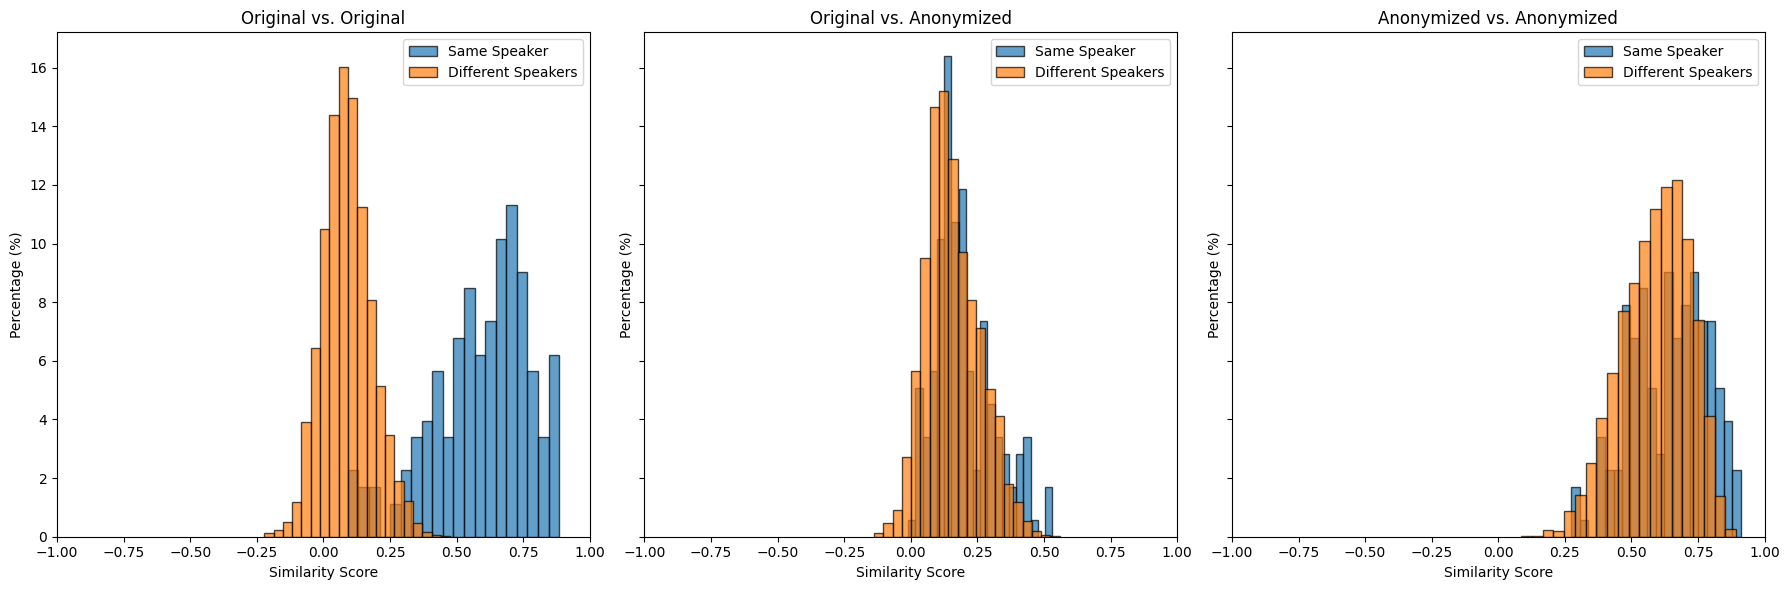

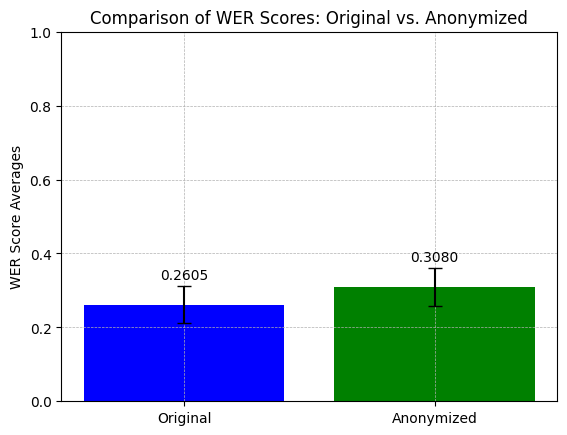

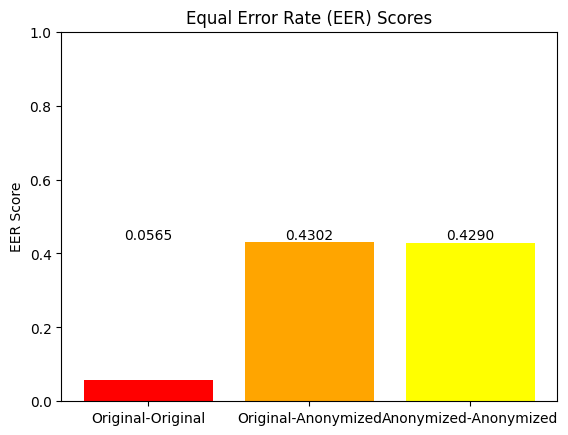

In [ ]:
visualize_metrics(metrics)